<a href="https://colab.research.google.com/github/pangwang83/pix2pix/blob/master/IA_Notebook_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


#Ruta raiz
PATH = "/content/drive/My Drive/flowersData"

# Ruta de datos de 
INPATH = PATH + '/inputFlowers'

# Ruta de datos de salida
OUPATH = PATH + '/targetFlowers'

# Ruta de los checkpoints
CKPATH = PATH + '/checkpoints'


imgurls = !ls -1 "{INPATH}"


n = 500
train_n = round(n * 0.80)

#Listado randomizado
randurls = np.copy(imgurls)

np.random.seed(23) #Importante: solo para el tutorial
np.random.shuffle(randurls)


#Particion train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

7725 400 100


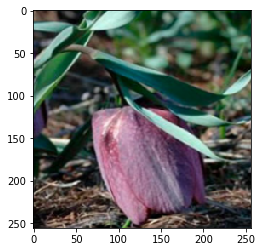

In [36]:
IMG_WIDTH = 256
IMG_HEIGTH = 256


# Reescalar imagenes
def resize (inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

def normalize(inimg, tgimg):
  inimg = (inimg /127.5) -1 
  tgimg = (tgimg / 127.5) -1 
  
  return inimg, tgimg


@tf.function()
# Aumnetacion de datos : Random Crop + Flip
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 286,286)
  
  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGTH, IMG_WIDTH,3])
  
  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
    
  return inimg, tgimg


def load_image(filename, augment=True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  reimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)[..., :3]
  
  inimg, reimg = resize(inimg, reimg, IMG_HEIGTH, IMG_WIDTH)
  
  if augment:
    inimg, reimg = random_jitter(inimg, reimg)
    
  inimg, reimg = normalize(inimg, reimg)
  
  return inimg, reimg



  
def load_train_image(filename):
  return load_image(filename, True)

 
def load_test_image(filename):
  return load_image(filename, False)



plt.imshow(((load_train_image(randurls[0])[1]) +1) /2)

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset= train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset= train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = train_dataset.batch(1)


TypeError: ignored

In [38]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  result = Sequential()
  
  
  initializer = tf.random_normal_initializer(0, 0.2)
  #Capa convolucional
  result.add(Conv2D(filters,
                   kernel_size=4,
                   strides=2,
                   padding="same",
                   kernel_initializer=initializer,
                   use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    #Capa de BatchNorm.
    result.add(BatchNormalization())
  
  #Capa de activacion
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [39]:
def upsample(filters, apply_dropout=False):
  result = Sequential()
  
  
  initializer = tf.random_normal_initializer(0, 0.2)
  #Capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  

  #Capa de BatchNorm.
  result.add(BatchNormalization())
  
  
  if apply_dropout:
    #Capa de Dropout
    result.add(Dropout(0.5))
  
  #Capa de activacion
  result.add(ReLU())
  
  return result


upsample(64)

In [0]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  down_stack = [
      downsample(64, apply_batchnorm=False),
      downsample(128),
      downsample(256),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512), 
  ]
  
  up_stack = [
      upsample(512, apply_dropout=True), 
      upsample(512, apply_dropout=True), 
      upsample(512, apply_dropout=True), 
      upsample(512), 
      upsample(256), 
      upsample(128), 
      upsample(64), 
  ]
  
  
  initializer = tf.random_normal_initializer(0, 0.2)
  
  last = Conv2DTranspose(filters = 3,
                        kernel_size = 4,
                        strides = 2,
                        padding = "same",
                        kernel_initializer = initializer,
                        activation = "tanh")
  
  x = inputs
  
  #skip connections
  s =[]
  
  
  concat = Concatenate()
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])

  for up, sk in zip(up_stack,s):
    x = up(x)
    x=concat([x,sk])
    
  last = last(x)
  
  return Model(inputs=inputs, outputs=last)

#To Test
generator = Generator()
#gen_output = generator(((inimg+1)*255),training=False)
#plt.imshow(gen_output[0,...])

In [0]:
def Discriminator():
  ini = Input(shape=[None, None,3], name="input_img")
  gen = Input(shape=[None, None,3], name="gener_img")
  
  con = concatenate([ini, gen])
  
  
  initializer = tf.random_normal_initializer(0, 0.2)
  
  
  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides = 1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  
  return tf.keras.Model(inputs=[ini,gen], outputs=last)
  

discriminator  = Discriminator()
#disc_out= discriminator([((inimg+1)*255), gen_output], training=False)
#plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
#plt.colorbar()
#disc_out.shape


In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  # Diferencia entre los true por ser real y el detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA + l1_loss)
  
  return total_gen_loss

In [29]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

#Restaurar checkpoint ( restaurar epochs)
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

NameError: ignored

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(title[i])
      # Getting the pixel values between [0,1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  
  plt.show()

In [0]:
@tf.function()
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
  
    output_image= generator(input_image, training=True)
    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr= discriminator([target, input_image], training=True)

    discr_loss=discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss=generator_loss(output_gen_discr, output_image, target)


    generator_grads=gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
  

In [0]:
from IPython.display import clear_output

#Define rutina de entrenamiento
def train(dataset, epochs):
  for epoch in range(epochs):
  
    imgi = 0
    for input_image, target in dataset:
      print('epoch '+ str(epoch) + ' -train: ' + str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
      
    imgi = 0  
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi +=1
    # saving (checkpoint) the model every 20 epochs
    
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
      

In [59]:
train(train_dataset, 100)

TypeError: ignored